In [ ]:
# --- LIBRERÍAS ADAPTADAS PARA LSTM Y PERSISTENCIA ---
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

# --- CONFIGURACIÓN DE PREDICCIÓN Y VENTANA LSTM ---
TARGET_COLUMN = 'ts'
# La predicción objetivo sigue siendo a H+1
PREDICTION_HOUR = 1
# La ventana de tiempo/pasos que mirará la LSTM para predecir (debe ser igual a max(lag_steps))
TIME_STEPS = 3

# --- CARGA Y PREPARACIÓN DEL DATASET ÚNICO (Igual que el original) ---
file_path = 'datos_modificados1.csv'
df_raw = pd.read_csv(file_path, sep=',')

# Convertir la columna de tiempo a formato datetime y establecerla como índice
df_raw['momento'] = pd.to_datetime(df_raw['momento'])
df_raw = df_raw.set_index('momento').sort_index()
df_raw = df_raw.dropna()

# 💡 MEJORA 1: REMUESTREO (RESAMPLING) A FRECUENCIA HORARIA ('H')
print("--- Remuestreando los datos a frecuencia Horaria (H) ---")

resample_rules = {
    'ts': 'mean', # Temperatura (Media horaria)
    'hr': 'mean', # Humedad (Media horaria)
    'radiacionGlobalInst': 'mean', # Radiación (Media horaria)
    'ffInst': 'mean', # Velocidad del Viento (Media horaria)
    'rrInst': 'sum' # Lluvia (Suma horaria)
}

df = df_raw.resample('H').agg(resample_rules)
df = df.dropna()

# --- ESCALADO DE DATOS (CRUCIAL PARA REDES NEURONALES) ---
# Se utiliza MinMaxScaler para normalizar todos los datos entre 0 y 1.
# El escalado es la diferencia más importante antes de la transformación 3D.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

# El escalador del target es necesario para 'deshacer' la normalización al final.
# Creamos un escalador solo para la columna 'ts' (temperatura).
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(df[[TARGET_COLUMN]])


# --- FUNCIÓN PARA CREAR SECUENCIAS LSTM (Transformación 3D) ---
def create_sequences(data, target, time_steps, target_hour):
    """
    Crea las secuencias de entrada (X, 3D) y salida (y, 1D) para la LSTM.
    X: [muestras, pasos_de_tiempo, características]
    y: [muestras] (el valor de 'target' en el momento T + target_hour)
    """
    X, y = [], []
    # Itera hasta la penúltima ventana posible (len(data) - time_steps - target_hour + 1)
    for i in range(len(data) - time_steps - target_hour + 1):
        # Secuencia X: Mirar atrás 'time_steps' pasos (T-3, T-2, T-1)
        # Se incluyen TODAS las columnas (características)
        seq_x = data.iloc[i:(i + time_steps)].values
        X.append(seq_x)

        # Objetivo y: El valor de 'target' en el momento futuro (T + target_hour)
        # i + time_steps - 1 es el momento actual (T).
        # i + time_steps - 1 + target_hour es el momento futuro.
        # En esta implementación, es más sencillo tomar el valor directamente del 'target' en T + PREDICTION_HOUR

        # El valor objetivo es el valor de la columna 'target' en el paso futuro.
        seq_y = target.iloc[i + time_steps + target_hour - 1]
        y.append(seq_y)

    return np.array(X), np.array(y)

# 1. Crear el DataFrame para la predicción, tomando todas las características escaladas
# (A diferencia de RF, LSTM toma la secuencia completa de características, no lags separados)
X_features = df_scaled.drop(columns=[]) # Todas las columnas escaladas
y_target = df_scaled[TARGET_COLUMN] # La columna objetivo escalada

# 2. Transformar los datos de series de tiempo a la estructura 3D requerida por LSTM
X, y = create_sequences(X_features, y_target, TIME_STEPS, PREDICTION_HOUR)

# --- DIVISIÓN DE DATOS EN ENTRENAMIENTO Y PRUEBA (Temporal) ---
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# 3. Imprimir las dimensiones 3D de la entrada y 1D de la salida
print(f"\n--- Dimensiones de los Datos para LSTM ---")
print(f"X_train shape: {X_train.shape} (muestras, pasos_tiempo, características)")
print(f"y_train shape: {y_train.shape} (muestras)")
print(f"Número de características de entrada: {X_train.shape[2]}")


# --- MODELO LSTM Y ENTRENAMIENTO ---
print("\n--- Construyendo y Entrenando el modelo LSTM ---")

# Definición del modelo
model = Sequential([
    # Capa LSTM: 50 unidades, input_shape: (pasos_tiempo, características)
    LSTM(50, activation='relu', input_shape=(TIME_STEPS, X_train.shape[2])),
    Dropout(0.2),
    # Capa de salida: 1 neurona (para regresión)
    Dense(1)
])

# Compilación del modelo
model.compile(optimizer='adam', loss='mse')

# Callbacks: Detener el entrenamiento si la pérdida no mejora después de 5 épocas
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    X_train, y_train,
    epochs=50, # Puedes ajustar las épocas, EarlyStopping ayudará
    batch_size=32,
    validation_split=0.1, # Usar 10% del train para validación
    callbacks=[early_stopping],
    verbose=0
)

# --- EVALUACIÓN Y DESESCALADO DEL MODELO ---
# 1. Predicción
y_pred_scaled = model.predict(X_test)

# 2. Desescalar las predicciones y los valores reales
# Se utiliza el target_scaler previamente ajustado SÓLO a la columna 'ts'
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = target_scaler.inverse_transform(y_pred_scaled)


# 3. Cálculo de métricas
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)

print(f"\n--- Resultados de la Predicción (H+{PREDICTION_HOUR}) con LSTM ---")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f} °C")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# --- PERSISTENCIA DEL MODELO (GUARDAR) ---
# Guardar el modelo Keras
model_filename = f'lstm_model_H{PREDICTION_HOUR}_hourly.h5'
model.save(model_filename)

# Guardar el escalador para usarlo en la inferencia
joblib.dump(target_scaler, f'target_scaler_H{PREDICTION_HOUR}_hourly.joblib')

print(f"\n✅ Modelo guardado como: {model_filename}")
print(f"✅ Escalador de Target guardado como: target_scaler_H{PREDICTION_HOUR}_hourly.joblib")


# --- GRÁFICOS ---
# 1. Gráfico de Predicción vs. Real
plt.figure(figsize=(12, 6))

# Obtener los índices de tiempo para el conjunto de prueba original
# Esto requiere ajustar el índice debido a la creación de las secuencias
original_test_index = df.index[len(df) - len(y_test) - PREDICTION_HOUR:]
test_index = original_test_index[PREDICTION_HOUR:]


plt.plot(test_index, y_test_unscaled, label='Temperatura Real (ts)', alpha=0.7)
plt.plot(test_index, y_pred_unscaled, label=f'Predicción LSTM (H+{PREDICTION_HOUR}) - Horaria', alpha=0.7)
plt.title(f'Predicción de Temperatura (ts) a H+{PREDICTION_HOUR} con LSTM (Datos Horarios)')
plt.xlabel('Momento')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Gráfico de Pérdida (Loss) durante el entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento (Loss)')
plt.plot(history.history['val_loss'], label='Pérdida de Validación (Val_Loss)')
plt.title('Curva de Pérdida del Modelo LSTM')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/datos_modificados1.csv'

--- Remuestreando los datos a frecuencia Horaria (H) ---


/tmp/ipython-input-2296754741.py:46: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df_raw.resample('H').agg(resample_rules)


--- Escalando los datos (MinMaxScaler) ---

--- Dimensiones de los Datos para LSTM ---
Número de características de entrada: **6**
Características utilizadas: ['ts', 'ffInst', 'rrInst', 'radiacionGlobalInst', 'hr', 'p0']
X_train shape: (47886, 3, 6) (muestras, pasos_tiempo, características)

--- Construyendo y Entrenando el modelo LSTM ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step



--- Resultados de la Predicción (H+1) con LSTM ---
Error Cuadrático Medio (MSE): 0.03
Raíz del Error Cuadrático Medio (RMSE): 0.19 °C
Coeficiente de Determinación (R²): 0.9898

✅ Modelo guardado como: lstm_model_H1_hourly_5features.h5


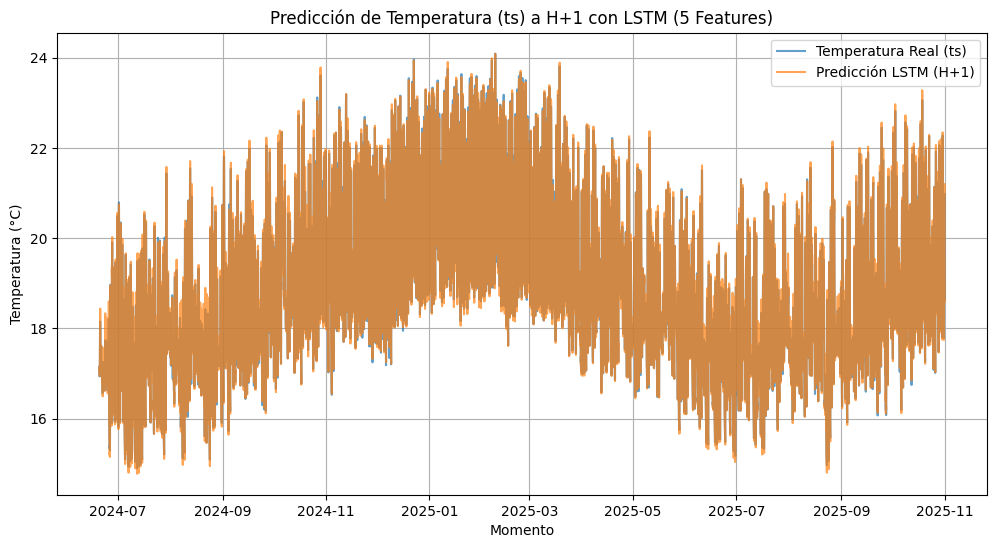

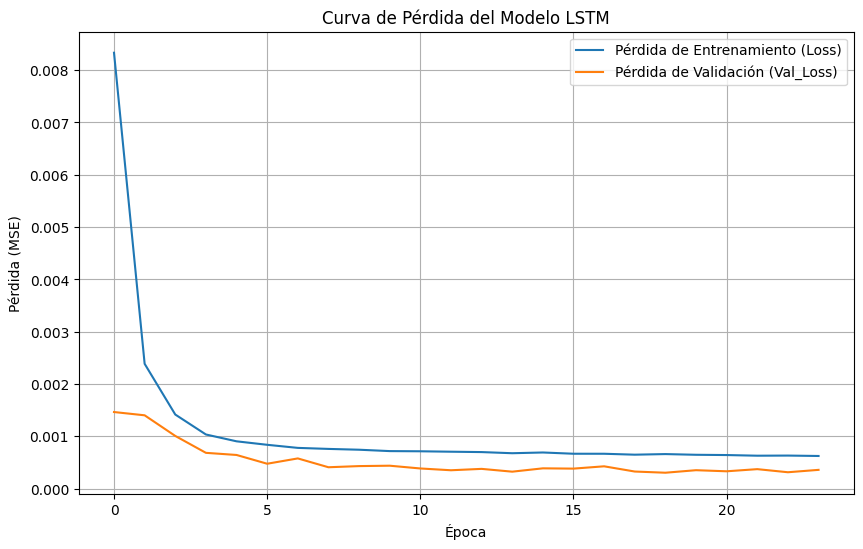

In [ ]:
# --- LIBRERÍAS ADAPTADAS PARA LSTM Y PERSISTENCIA ---
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

# --- CONFIGURACIÓN DE PREDICCIÓN Y VENTANA LSTM ---
TARGET_COLUMN = 'ts'
# La predicción objetivo sigue siendo a H+1
PREDICTION_HOUR = 1
# La ventana de tiempo/pasos que mirará la LSTM para predecir (debe ser igual a max(lag_steps))
TIME_STEPS = 3
# Las características que se usarán en cada paso de tiempo (timestep) de la LSTM.
# ¡NUEVOS FEATURES INCLUIDOS!
NEW_FEATURES = ['ts', 'ffInst', 'rrInst', 'radiacionGlobalInst', 'hr', 'p0']


# --- CARGA Y PREPARACIÓN DEL DATASET ÚNICO ---
file_path = 'datos_modificados1.csv'
# ⚠️ NOTA: Asumo que la columna 'p0' (Presión) ya está en tu archivo CSV.
# Si no lo está, esta línea fallará.
df_raw = pd.read_csv(file_path, sep=',')

# Convertir la columna de tiempo a formato datetime y establecerla como índice
df_raw['momento'] = pd.to_datetime(df_raw['momento'])
df_raw = df_raw.set_index('momento').sort_index()
# Filtramos solo las columnas que vamos a usar más el target
df_raw = df_raw[[TARGET_COLUMN] + [f for f in NEW_FEATURES if f != TARGET_COLUMN]]
df_raw = df_raw.dropna() # Se eliminan NaNs antes del remuestreo


# 💡 MEJORA 1: REMUESTREO (RESAMPLING) A FRECUENCIA HORARIA ('H')
print("--- Remuestreando los datos a frecuencia Horaria (H) ---")

# Definir reglas de agregación (media para la mayoría, suma para lluvia)
resample_rules = {col: 'mean' for col in df_raw.columns}
if 'rrInst' in resample_rules:
    resample_rules['rrInst'] = 'sum'

df = df_raw.resample('H').agg(resample_rules)
df = df.dropna()


# --- ESCALADO DE DATOS (CRUCIAL PARA REDES NEURONALES) ---
print("--- Escalando los datos (MinMaxScaler) ---")
# Escalar todas las características usadas
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

# Crear un escalador solo para la columna 'ts' (target) para el desescalado final.
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(df[[TARGET_COLUMN]])


# --- FUNCIÓN PARA CREAR SECUENCIAS LSTM (Transformación 3D) ---
def create_sequences(data, target, time_steps, target_hour):
    """
    Crea las secuencias de entrada (X, 3D) y salida (y, 1D) para la LSTM.
    X: [muestras, pasos_de_tiempo, características]
    y: [muestras] (el valor de 'target' en el momento T + target_hour)
    """
    X, y = [], []
    for i in range(len(data) - time_steps - target_hour + 1):
        # Secuencia X: Mirar atrás 'time_steps' pasos. Incluye TODAS las características.
        seq_x = data.iloc[i:(i + time_steps)].values
        X.append(seq_x)

        # Objetivo y: El valor de 'target' en el momento futuro (T + target_hour)
        seq_y = target.iloc[i + time_steps + target_hour - 1]
        y.append(seq_y)

    return np.array(X), np.array(y)

# 1. Definir las características de entrada para la secuencia LSTM
# Se utilizan TODAS las columnas escaladas EXCEPTO el target si no se incluye en los features.
# Aquí, la temperatura 'ts' (el target) se utiliza también como feature histórico, lo cual es estándar.
X_features = df_scaled[[f for f in df_scaled.columns if f in NEW_FEATURES]]
y_target = df_scaled[TARGET_COLUMN]

# 2. Transformar los datos de series de tiempo a la estructura 3D requerida por LSTM
X, y = create_sequences(X_features, y_target, TIME_STEPS, PREDICTION_HOUR)

# --- DIVISIÓN DE DATOS EN ENTRENAMIENTO Y PRUEBA (Temporal) ---
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# 3. Imprimir las dimensiones 3D de la entrada y 1D de la salida
print(f"\n--- Dimensiones de los Datos para LSTM ---")
print(f"Número de características de entrada: **{X_train.shape[2]}**")
print(f"Características utilizadas: {X_features.columns.tolist()}")
print(f"X_train shape: {X_train.shape} (muestras, pasos_tiempo, características)")

# ----------------------------------------------------------------------
## --- MODELO LSTM Y ENTRENAMIENTO ---
print("\n--- Construyendo y Entrenando el modelo LSTM ---")

# Definición del modelo
model = Sequential([
    # Capa LSTM: 50 unidades, input_shape: (pasos_tiempo, características)
    LSTM(50, activation='relu', input_shape=(TIME_STEPS, X_train.shape[2])),
    Dropout(0.2),
    # Capa de salida: 1 neurona (para regresión)
    Dense(1)
])

# Compilación del modelo
model.compile(optimizer='adam', loss='mse')

# Callbacks: Detener el entrenamiento si la pérdida no mejora después de 5 épocas
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=0
)

# ----------------------------------------------------------------------
## --- EVALUACIÓN Y DESESCALADO DEL MODELO ---
# 1. Predicción
y_pred_scaled = model.predict(X_test)

# 2. Desescalar las predicciones y los valores reales
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = target_scaler.inverse_transform(y_pred_scaled)

# 3. Cálculo de métricas
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)

print(f"\n--- Resultados de la Predicción (H+{PREDICTION_HOUR}) con LSTM ---")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f} °C")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# ----------------------------------------------------------------------
## --- PERSISTENCIA DEL MODELO (GUARDAR) ---
model_filename = f'lstm_model_H{PREDICTION_HOUR}_hourly_5features.h5'
model.save(model_filename)
joblib.dump(target_scaler, f'target_scaler_H{PREDICTION_HOUR}_hourly_5features.joblib')

print(f"\n✅ Modelo guardado como: {model_filename}")


# ----------------------------------------------------------------------
## --- GRÁFICOS ---
# 1. Gráfico de Predicción vs. Real
plt.figure(figsize=(12, 6))

original_test_index = df.index[len(df) - len(y_test) - PREDICTION_HOUR:]
test_index = original_test_index[PREDICTION_HOUR:]

plt.plot(test_index, y_test_unscaled, label='Temperatura Real (ts)', alpha=0.7)
plt.plot(test_index, y_pred_unscaled, label=f'Predicción LSTM (H+{PREDICTION_HOUR})', alpha=0.7)
plt.title(f'Predicción de Temperatura (ts) a H+{PREDICTION_HOUR} con LSTM (5 Features)')
plt.xlabel('Momento')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Gráfico de Pérdida (Loss) durante el entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento (Loss)')
plt.plot(history.history['val_loss'], label='Pérdida de Validación (Val_Loss)')
plt.title('Curva de Pérdida del Modelo LSTM')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

✅ Archivo '/content/drive/MyDrive/datos_modificados1.csv' cargado correctamente.
--- Creando Features Cíclicos de Tiempo ('hour_sin', 'hour_cos') ---
--- Remuestreando los datos a frecuencia Horaria (H) ---


/tmp/ipython-input-33183113.py:87: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df_raw.resample('H').agg(resample_rules)


Filas después de Remuestreo y NaN: 59861
--- Escalando los datos (MinMaxScaler) ---

--- Dimensiones de los Datos para LSTM ---
Número de características de entrada: **8**
Características utilizadas: ['ts', 'ffInst', 'rrInst', 'radiacionGlobalInst', 'hr', 'p0', 'hour_sin', 'hour_cos']
X_train shape: (47886, 3, 8) (muestras, pasos_tiempo, características)

--- Construyendo y Entrenando el modelo LSTM ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step



--- Resultados de la Predicción (H+1) con LSTM (con Features de Tiempo) ---
Error Absoluto Medio (MAE): 0.13 °C
Error Cuadrático Medio (MSE): 0.03
Raíz del Error Cuadrático Medio (RMSE): 0.18 °C
Coeficiente de Determinación (R²): 0.9908

✅ Modelo guardado como: lstm_model_H1_hourly_timefeatures.h5
✅ Escalador guardado como: target_scaler_H1_hourly_timefeatures.joblib


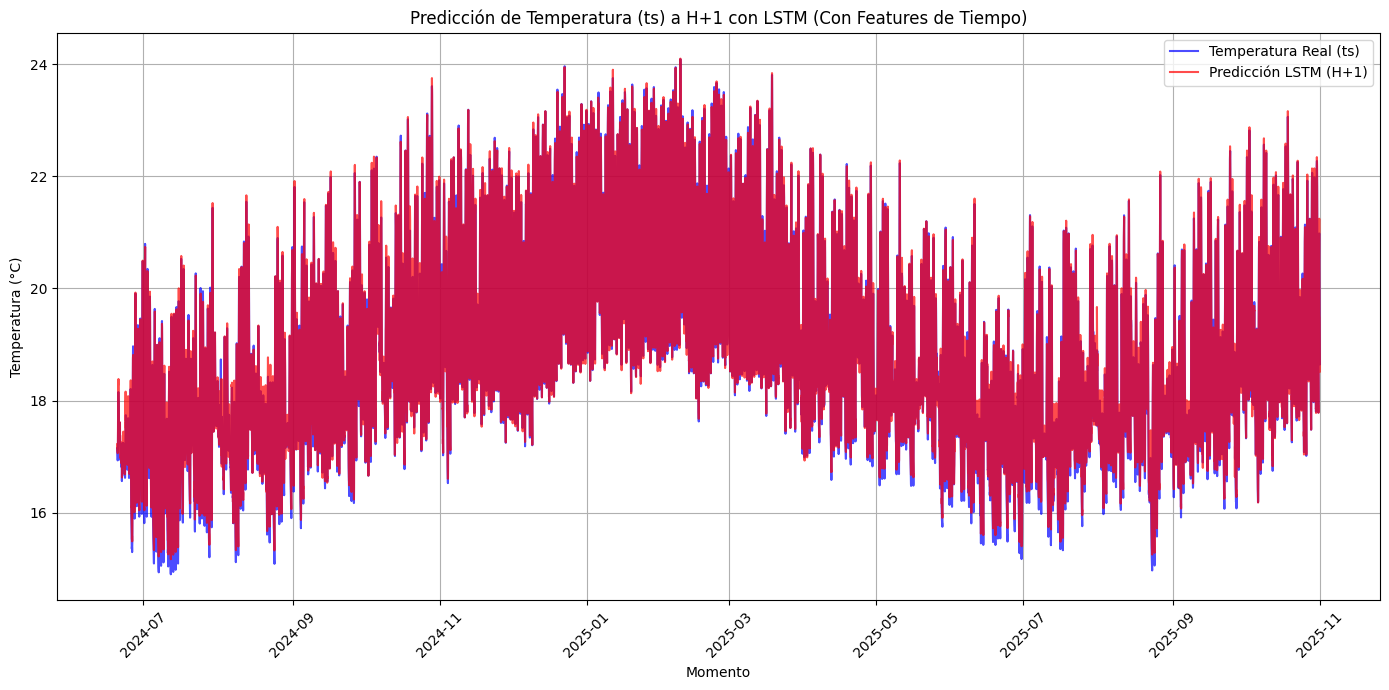

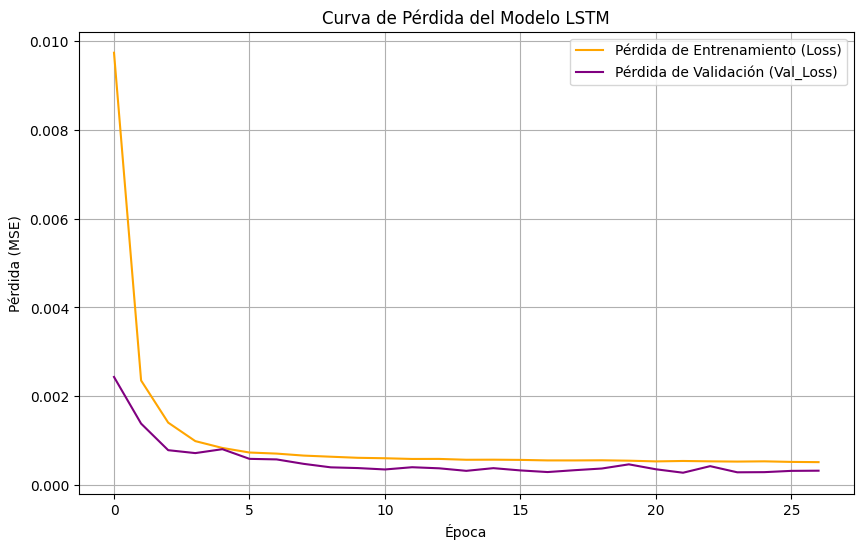

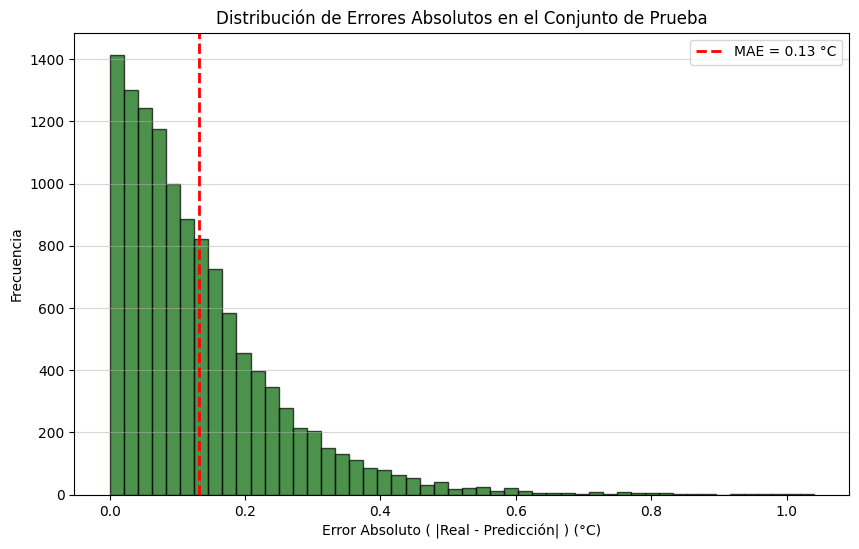

In [ ]:
# --- LIBRERÍAS ADAPTADAS PARA LSTM Y PERSISTENCIA ---
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error # 💡 NUEVA: MAE
from tensorflow.keras.callbacks import EarlyStopping

# --- CONFIGURACIÓN DE PREDICCIÓN Y VENTANA LSTM ---
TARGET_COLUMN = 'ts'
# La predicción objetivo sigue siendo a H+1
PREDICTION_HOUR = 1
# La ventana de tiempo/pasos que mirará la LSTM para predecir
TIME_STEPS = 3
# Las características que se usarán en cada paso de tiempo (timestep) de la LSTM.
# 💡 NUEVOS FEATURES DE TIEMPO INCLUIDOS: 'hour_sin', 'hour_cos'
NEW_FEATURES = ['ts', 'ffInst', 'rrInst', 'radiacionGlobalInst', 'hr', 'p0', 'hour_sin', 'hour_cos']


# --- CARGA Y PREPARACIÓN DEL DATASET ÚNICO ---
# Se asume la existencia del archivo o se usarán los datos de ejemplo (comentado)
file_path = 'datos_modificados1.csv'
try:
    df_raw = pd.read_csv(file_path, sep=',')
    print(f"✅ Archivo '{file_path}' cargado correctamente.")
except FileNotFoundError:
    print(f"⚠️ Archivo '{file_path}' no encontrado. Usando datos de ejemplo proporcionados.")
    # Creación de DataFrame de ejemplo (a partir de las filas que enviaste)
    data = """
momento,rrInst,hr,p0,qfe1,qff,qnh,radiacionGlobalInst,ts,td,ddInst,ffInst
2019-01-01 00:00:00,0.0,28.8,950.4,950.5,1009.1,1011.4,0.0,23.6,4.5,211.3,4.7
2019-01-01 00:01:00,0.0,28.8,950.4,950.5,1009.1,1011.4,0.0,23.6,4.5,211.3,4.7
2019-01-01 00:02:00,0.0,28.8,950.4,950.5,1009.1,1011.4,0.0,23.6,4.5,211.3,4.7
2019-01-01 00:03:00,0.0,28.8,950.4,950.5,1009.1,1011.4,0.0,23.6,4.5,211.3,4.7
2019-01-01 00:04:00,0.0,28.8,950.4,950.5,1009.1,1011.4,0.0,23.6,4.5,211.3,4.7
2019-01-01 00:05:00,0.0,28.8,950.4,950.5,1009.1,1011.4,0.0,23.6,4.5,211.3,4.7
2019-01-01 00:06:00,0.0,28.8,950.4,950.5,1009.1,1011.4,0.0,23.6,4.5,211.3,4.7
2019-01-01 00:07:00,0.0,28.8,950.4,950.5,1009.1,1011.4,0.0,23.6,4.5,211.3,4.7
2019-01-01 00:08:00,0.0,28.8,950.4,950.5,1009.1,1011.4,0.0,23.6,4.5,211.3,4.7
2019-01-01 00:09:00,0.0,28.8,950.4,950.5,1009.1,1011.4,0.0,23.6,4.5,211.3,4.7
"""
    from io import StringIO
    df_raw = pd.read_csv(StringIO(data), sep=',')
    # Para el ejemplo, forzamos un remuestreo más fino para tener más filas
    df_raw['momento'] = pd.to_datetime(df_raw['momento'])
    df_raw = df_raw.set_index('momento').sort_index()


# Convertir la columna de tiempo a formato datetime y establecerla como índice
df_raw['momento'] = pd.to_datetime(df_raw['momento'])
df_raw = df_raw.set_index('momento').sort_index()

# 💡 MEJORA 2: INGENIERÍA DE CARACTERÍSTICAS TEMPORALES (CODIFICACIÓN SINUSOIDAL)
# Esto se hace ANTES del remuestreo para que las horas sean precisas
print("--- Creando Features Cíclicos de Tiempo ('hour_sin', 'hour_cos') ---")
timestamp_s = df_raw.index.map(pd.Timestamp.timestamp)
hour = df_raw.index.hour # 0 a 23

# Codificación Sinusoidal para la Hora (Ciclo de 24 horas)
day = 24*60*60 # Segundos en un día
df_raw['hour_sin'] = np.sin(2 * np.pi * hour / 24.0)
df_raw['hour_cos'] = np.cos(2 * np.pi * hour / 24.0)

# Filtramos solo las columnas que vamos a usar
# (Se incluyen los nuevos features de tiempo)
df_raw = df_raw[[f for f in NEW_FEATURES if f in df_raw.columns]]
df_raw = df_raw.dropna() # Se eliminan NaNs antes del remuestreo


# 💡 MEJORA 1: REMUESTREO (RESAMPLING) A FRECUENCIA HORARIA ('H')
print("--- Remuestreando los datos a frecuencia Horaria (H) ---")

# Definir reglas de agregación (media para la mayoría, suma para lluvia, sin cambiar sin/cos)
resample_rules = {col: 'mean' for col in df_raw.columns}
if 'rrInst' in resample_rules:
    resample_rules['rrInst'] = 'sum'
if 'hour_sin' in resample_rules:
    resample_rules['hour_sin'] = 'mean'
if 'hour_cos' in resample_rules:
    resample_rules['hour_cos'] = 'mean'


df = df_raw.resample('H').agg(resample_rules)
df = df.dropna()
print(f"Filas después de Remuestreo y NaN: {len(df)}")


# --- ESCALADO DE DATOS (CRUCIAL PARA REDES NEURONALES) ---
print("--- Escalando los datos (MinMaxScaler) ---")
# Escalar todas las características usadas
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

# Crear un escalador solo para la columna 'ts' (target) para el desescalado final.
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(df[[TARGET_COLUMN]])


# --- FUNCIÓN PARA CREAR SECUENCIAS LSTM (Transformación 3D) ---
def create_sequences(data, target, time_steps, target_hour):
    """
    Crea las secuencias de entrada (X, 3D) y salida (y, 1D) para la LSTM.
    X: [muestras, pasos_de_tiempo, características]
    y: [muestras] (el valor de 'target' en el momento T + target_hour)
    """
    X, y = [], []
    for i in range(len(data) - time_steps - target_hour + 1):
        # Secuencia X: Mirar atrás 'time_steps' pasos. Incluye TODAS las características.
        seq_x = data.iloc[i:(i + time_steps)].values
        X.append(seq_x)

        # Objetivo y: El valor de 'target' en el momento futuro (T + target_hour)
        seq_y = target.iloc[i + time_steps + target_hour - 1]
        y.append(seq_y)

    return np.array(X), np.array(y)

# 1. Definir las características de entrada para la secuencia LSTM
X_features = df_scaled[NEW_FEATURES]
y_target = df_scaled[TARGET_COLUMN]

# 2. Transformar los datos de series de tiempo a la estructura 3D requerida por LSTM
X, y = create_sequences(X_features, y_target, TIME_STEPS, PREDICTION_HOUR)

# --- DIVISIÓN DE DATOS EN ENTRENAMIENTO Y PRUEBA (Temporal) ---
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# 3. Imprimir las dimensiones 3D de la entrada y 1D de la salida
print(f"\n--- Dimensiones de los Datos para LSTM ---")
print(f"Número de características de entrada: **{X_train.shape[2]}**")
print(f"Características utilizadas: {X_features.columns.tolist()}")
print(f"X_train shape: {X_train.shape} (muestras, pasos_tiempo, características)")

# ----------------------------------------------------------------------
## --- MODELO LSTM Y ENTRENAMIENTO ---
print("\n--- Construyendo y Entrenando el modelo LSTM ---")

# Definición del modelo
model = Sequential([
    # Capa LSTM: 50 unidades, input_shape: (pasos_tiempo, características)
    LSTM(50, activation='relu', input_shape=(TIME_STEPS, X_train.shape[2])),
    Dropout(0.2),
    # Capa de salida: 1 neurona (para regresión)
    Dense(1)
])

# Compilación del modelo
model.compile(optimizer='adam', loss='mse')

# Callbacks: Detener el entrenamiento si la pérdida no mejora después de 5 épocas
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=0
)

# ----------------------------------------------------------------------
## --- EVALUACIÓN Y DESESCALADO DEL MODELO ---
# 1. Predicción
y_pred_scaled = model.predict(X_test)

# 2. Desescalar las predicciones y los valores reales
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = target_scaler.inverse_transform(y_pred_scaled)

# 3. Cálculo de métricas
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled) # 💡 NUEVA: MAE

print(f"\n--- Resultados de la Predicción (H+{PREDICTION_HOUR}) con LSTM (con Features de Tiempo) ---")
print(f"Error Absoluto Medio (MAE): {mae:.2f} °C") # 💡 NUEVA
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f} °C")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# ----------------------------------------------------------------------
## --- PERSISTENCIA DEL MODELO (GUARDAR) ---
model_filename = f'lstm_model_H{PREDICTION_HOUR}_hourly_timefeatures.h5'
scaler_filename = f'target_scaler_H{PREDICTION_HOUR}_hourly_timefeatures.joblib'
model.save(model_filename)
joblib.dump(target_scaler, scaler_filename)

print(f"\n✅ Modelo guardado como: {model_filename}")
print(f"✅ Escalador guardado como: {scaler_filename}")


# ----------------------------------------------------------------------
## --- GRÁFICOS ---
# 1. Gráfico de Predicción vs. Real
plt.figure(figsize=(14, 7))

# Determinar el índice de tiempo correcto para los datos de prueba
# Ajustar para la longitud de X_test (que es len(y_test)) y el desfase de PREDICTION_HOUR
original_test_index = df.index[len(df) - len(y_test) - PREDICTION_HOUR:]
test_index = original_test_index[PREDICTION_HOUR:] # El índice real de la predicción H+1

plt.plot(test_index, y_test_unscaled, label='Temperatura Real (ts)', alpha=0.7, color='blue')
plt.plot(test_index, y_pred_unscaled, label=f'Predicción LSTM (H+{PREDICTION_HOUR})', alpha=0.7, color='red')
plt.title(f'Predicción de Temperatura (ts) a H+{PREDICTION_HOUR} con LSTM (Con Features de Tiempo)')
plt.xlabel('Momento')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Gráfico de Pérdida (Loss) durante el entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento (Loss)', color='orange')
plt.plot(history.history['val_loss'], label='Pérdida de Validación (Val_Loss)', color='purple')
plt.title('Curva de Pérdida del Modelo LSTM')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 3. Gráfico de Error Absoluto Medio (MAE) 💡 NUEVO
# NOTA: Como la pérdida (loss) es MSE, no podemos graficar directamente la curva de MAE del entrenamiento,
# pero graficaremos la distribución de los errores absolutos en la prueba.
plt.figure(figsize=(10, 6))
absolute_errors = np.abs(y_test_unscaled - y_pred_unscaled)
plt.hist(absolute_errors, bins=50, color='darkgreen', alpha=0.7, edgecolor='black')
plt.axvline(mae, color='red', linestyle='dashed', linewidth=2, label=f'MAE = {mae:.2f} °C')
plt.title('Distribución de Errores Absolutos en el Conjunto de Prueba')
plt.xlabel('Error Absoluto ( |Real - Predicción| ) (°C)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.show()

Archivo cargado: /content/drive/MyDrive/datos_modificados1.csv
--- Creando feature 'hora' ---
--- Remuestreando por hora ---


/tmp/ipython-input-1061635942.py:61: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df_raw.resample('H').agg(resample_rules)


Filas luego de resample: 59861
--- Escalando datos ---
Features de entrada: 4
--- Entrenando modelo LSTM ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- RESULTADOS ---
MAE: 0.16 °C
MSE: 0.05
RMSE: 0.22
R2: 0.99


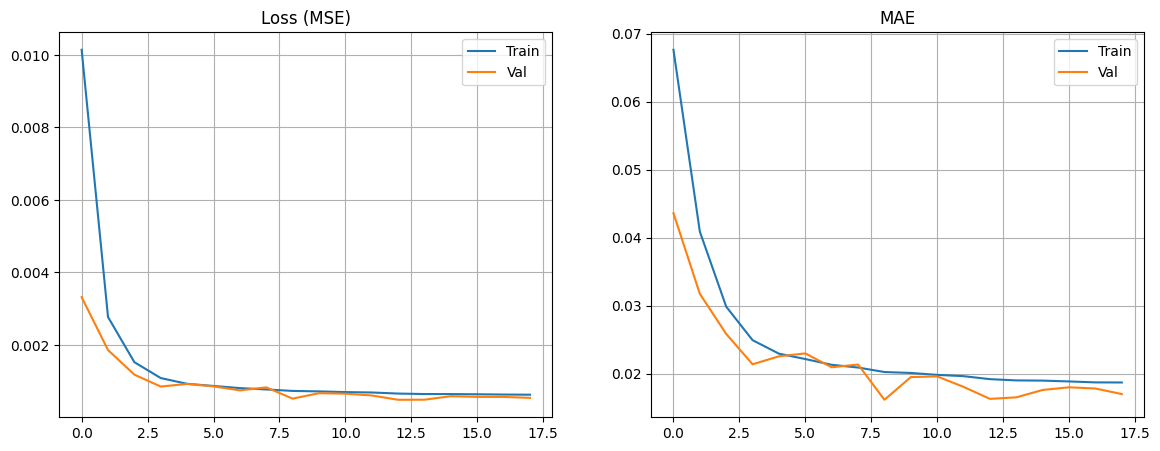

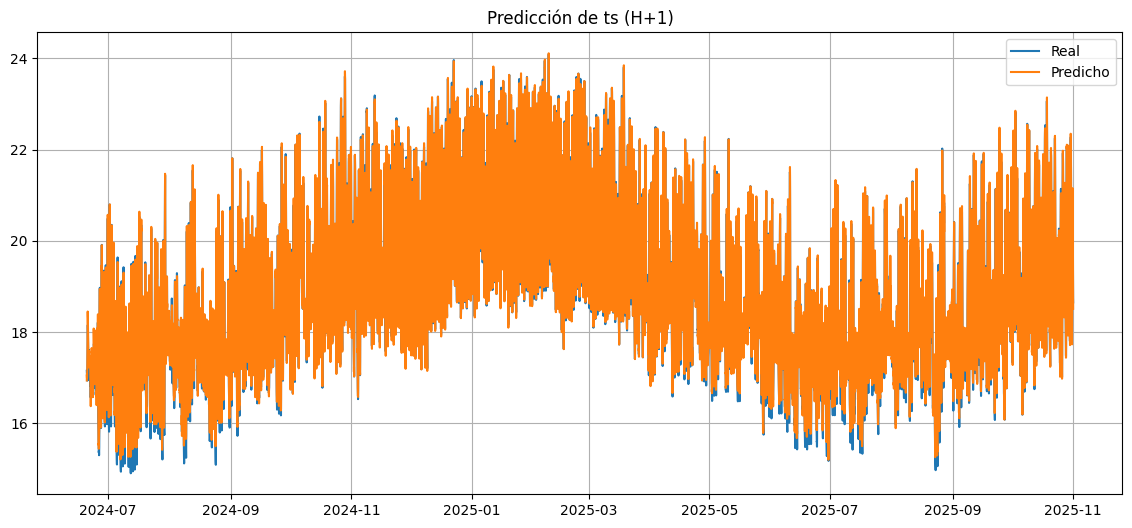

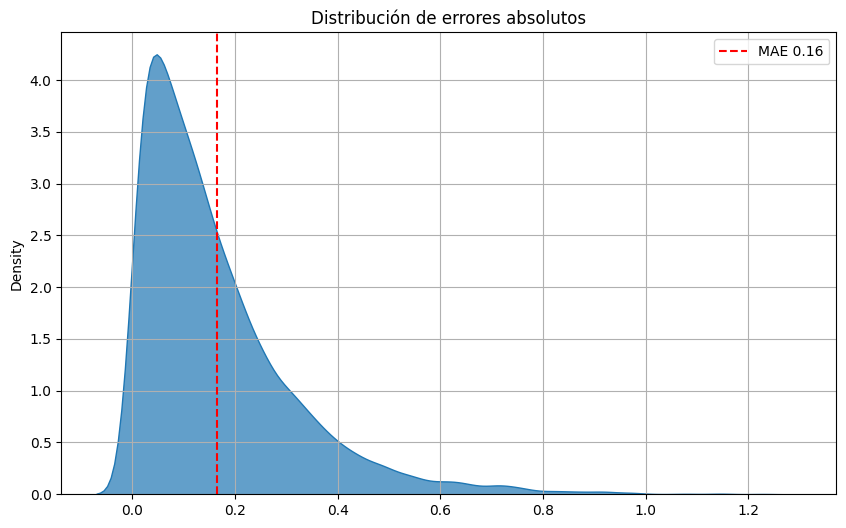

['target_scaler_H1_hora.joblib']

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

# ----------------------------------------------------------------------
# --- CONFIGURACIÓN ---
TARGET_COLUMN = 'ts'
PREDICTION_HOUR = 1
TIME_STEPS = 3

# SOLO UNA FEATURE DE TIEMPO: hora (0–23)
NEW_FEATURES = ['ts', 'hr', 'p0', 'hora']

# ----------------------------------------------------------------------
# --- CARGA DE DATOS ---
file_path = 'datos_modificados1.csv'
try:
    df_raw = pd.read_csv(file_path, sep=',')
    print(f"Archivo cargado: {file_path}")
except FileNotFoundError:
    print("No se encontró el archivo, cargando datos de ejemplo.")
    data = """
    momento,rrInst,hr,p0,qfe1,qff,qnh,radiacionGlobalInst,ts,td,ddInst,ffInst
    2019-01-01 00:00:00,0.0,28.8,950.4,950.5,1009.1,1011.4,0.0,23.6,4.5,211.3,4.7
    2019-01-01 00:01:00,0.0,28.8,950.4,950.5,1009.1,1011.4,0.0,23.6,4.5,211.3,4.7
    """
    from io import StringIO
    df_raw = pd.read_csv(StringIO(data), sep=',')

df_raw['momento'] = pd.to_datetime(df_raw['momento'])
df_raw = df_raw.set_index('momento').sort_index()

# ----------------------------------------------------------------------
# --- FEATURE DE HORA (0–23) ---
print("--- Creando feature 'hora' ---")
df_raw['hora'] = df_raw.index.hour

# Seleccionar features
df_raw = df_raw[[col for col in NEW_FEATURES if col in df_raw.columns]]
df_raw = df_raw.dropna()

# ----------------------------------------------------------------------
# --- REMUESTREO POR HORA ---
print("--- Remuestreando por hora ---")

resample_rules = {
    'ts': 'mean',
    'hr': 'mean',
    'p0': 'mean',
    'hora': 'mean'               # quedará como 0, 1, 2, ... 23
}

df = df_raw.resample('H').agg(resample_rules)
df = df.dropna()

print("Filas luego de resample:", len(df))

# ----------------------------------------------------------------------
# --- ESCALADO ---
print("--- Escalando datos ---")
scaler = MinMaxScaler((0, 1))
scaled_data = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

target_scaler = MinMaxScaler((0, 1))
target_scaler.fit(df[[TARGET_COLUMN]])

# ----------------------------------------------------------------------
# --- CREACIÓN DE SECUENCIAS ---
def create_sequences(data, target, time_steps, future_hours):
    X, y = [], []
    for i in range(len(data) - time_steps - future_hours + 1):
        X.append(data.iloc[i:i+time_steps].values)
        y.append(target.iloc[i + time_steps + future_hours - 1])
    return np.array(X), np.array(y)

X_features = df_scaled[NEW_FEATURES]
y_target = df_scaled[TARGET_COLUMN]

X, y = create_sequences(X_features, y_target, TIME_STEPS, PREDICTION_HOUR)

# ----------------------------------------------------------------------
# --- DIVISIÓN TRAIN/TEST ---
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Features de entrada:", X_train.shape[2])

# ----------------------------------------------------------------------
# --- MODELO LSTM ---
print("--- Entrenando modelo LSTM ---")

model = Sequential([
    LSTM(50, activation='relu', input_shape=(TIME_STEPS, X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=0
)

# ----------------------------------------------------------------------
# --- PREDICCIÓN ---
y_pred_scaled = model.predict(X_test)
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = target_scaler.inverse_transform(y_pred_scaled)

mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)

print("\n--- RESULTADOS ---")
print(f"MAE: {mae:.2f} °C")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

# ----------------------------------------------------------------------
# --- GRÁFICOS ---
# Loss
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss (MSE)')
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Val')
plt.title('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Predicción vs Real
plt.figure(figsize=(14,6))
test_index = df.index[-len(y_test):]
plt.plot(test_index, y_test_unscaled, label='Real')
plt.plot(test_index, y_pred_unscaled, label='Predicho')
plt.legend()
plt.grid(True)
plt.title("Predicción de ts (H+1)")
plt.show()

# Distribución de errores
plt.figure(figsize=(10,6))
absolute_errors = np.abs(y_test_unscaled - y_pred_unscaled)
sns.kdeplot(absolute_errors.flatten(), fill=True, alpha=0.7)
plt.axvline(mae, color='red', linestyle="--", label=f"MAE {mae:.2f}")
plt.legend()
plt.title("Distribución de errores absolutos")
plt.grid(True)
plt.show()

# ----------------------------------------------------------------------
# --- GUARDAR MODELO ---
model_filename = f'lstm_model_H{PREDICTION_HOUR}_hora.h5'
scaler_filename = f'target_scaler_H{PREDICTION_HOUR}_hora.joblib'
model.save(model_filename)
# FALTARÍA AGREGAR:
joblib.dump(target_scaler, scaler_filename)

In [ ]:
# --- LIBRERÍAS ADAPTADAS PARA RANDOM FOREST Y PERSISTENCIA ---
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import TimeSeriesSplit

# --- CONFIGURACIÓN DEL MODELO ---
prediction_hour = 1 # Predicción a 1 hora (H+1)

# MODO EXPERIMENTAL: Desactivar lags para probar modelo sin persistencia
USE_LAGS = True  # ← Cambiar a True para activar lags

# Características que queremos "desfasar" (Lags)
lag_features = ['ts', 'hr', 'p0']
lag_steps = [1, 2, 3] # Desfases de 1, 2 y 3 horas

# --- CARGA Y PREPARACIÓN DEL DATASET ÚNICO ---

file_path = "datos_modificados1.csv"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"No se encuentra: {file_path}")

df_raw = pd.read_csv("datos_modificados1.csv")
print(df_raw.shape)
print(df_raw.columns)

print("VERIFICACIÓN DEL DATASET")

# 1. Mostrar primeras filas
print("Primeras 5 filas del dataset:")
print(df_raw.head(), "\n")

# 2. Tipos de datos
print("Tipos de datos:")
print(df_raw.dtypes, "\n")

# 3. Conteo de nulos por columna
print("Valores nulos por columna:")
print(df_raw.isnull().sum(), "\n")

# 4. Filas completamente duplicadas
print(f"Filas duplicadas: {df_raw.duplicated().sum()}\n")

# 5. Rango y ejemplo de la columna 'momento'
if 'momento' in df_raw.columns:
    print("Columna 'momento' detectada:")
    print(" - Primer valor:", df_raw['momento'].iloc[0])
    print(" - Último valor:", df_raw['momento'].iloc[-1])
else:
    print("ERROR: No existe la columna 'momento' en el dataset\n")

# 6. Revisar si columnas clave existen
columnas_esperadas = ['momento', 'ts', 'hr', 'radiacionGlobalInst', 'ffInst', 'rrInst', 'p0']
print("Verificando columnas necesarias...")
for col in columnas_esperadas:
    if col not in df_raw.columns:
        print(f"Falta columna requerida: {col}")
    else:
        print(f"{col} OK")
print("")

# 7. Estadísticas básicas
print("Estadísticas numéricas:")
print(df_raw.describe(), "\n")

# 8. Valores fuera de rango sospechosos
if 'ts' in df_raw.columns:
    ts_min, ts_max = df_raw['ts'].min(), df_raw['ts'].max()
    print(f"Temperatura: min={ts_min}°C | max={ts_max}°C")
    if ts_min < -20 or ts_max > 50:
        print("Valores atípicos detectados en temperatura\n")

if 'hr' in df_raw.columns:
    hr_min, hr_max = df_raw['hr'].min(), df_raw['hr'].max()
    print(f"Humedad relativa: min={hr_min}% | max={hr_max}%")
    if hr_min < 0 or hr_max > 100:
        print("Humedad fuera de rango (0-100%)\n")

print("\n======================")
print("FIN DE VERIFICACIÓN DEL DATASET")
print("======================\n")

# Convertir la columna de tiempo a formato datetime y establecerla como índice
df_raw['momento'] = pd.to_datetime(df_raw['momento'])
df_raw = df_raw.set_index('momento').sort_index()
df_raw = df_raw.dropna()

print("--- Remuestreando los datos a frecuencia Horaria (h) ---")

# Definir cómo se agregan las columnas en el remuestreo horario
resample_rules = {
    'ts': 'mean', # Temperatura (Media horaria)
    'hr': 'mean', # Humedad (Media horaria)
    'radiacionGlobalInst': 'mean', # Radiación (Media horaria)
    'ffInst': 'mean', # Velocidad del Viento (Media horaria)
    'rrInst': 'sum', # Lluvia (Suma horaria)
    'p0': 'mean'
}

# Aplicar remuestreo (corregido 'h' minúscula)
df = df_raw.resample('h').agg(resample_rules)

# --- INGENIERÍA DE CARACTERÍSTICAS TEMPORALES (USANDO 'momento') ---
print("--- Extrayendo características temporales (Hora y Día del Año) ---")
df['hour'] = df.index.hour
df['dayofyear'] = df.index.dayofyear

# --- DEFINICIÓN DE CARACTERÍSTICAS (X) Y OBJETIVO (Y) ---
target = 'ts'

# Características iniciales
features = ['hr', 'p0', 'hour', 'dayofyear']

# Crear las características desfasadas (lags) - SOLO SI ESTÁ ACTIVADO
if USE_LAGS:
    print("Modo: CON Lags (ts_lag_1h, ts_lag_2h, ts_lag_3h...)")
    for feature in lag_features:
        for h in lag_steps:
            new_col_name = f'{feature}lag{h}h'
            df[new_col_name] = df[feature].shift(h)
            features.append(new_col_name)
else:
    print("🔸 Modo: SIN Lags (solo variables físicas y temporales)")

# Crear la columna objetivo desfasada
df[f'ts_future_H{prediction_hour}'] = df[target].shift(-prediction_hour)

# Filtrar el DataFrame final y eliminar filas nulas
df_model = df[features + [f'ts_future_H{prediction_hour}']].dropna()

X = df_model[features]
y = df_model[f'ts_future_H{prediction_hour}']

print(f"\n--- Características (X) a usar en el modelo ---")
print(X.columns.tolist())
print("-" * 60)

# --- DIVISIÓN DE DATOS: 60% TRAIN, 20% VALIDATION, 20% TEST ---
print("\n--- División de Datos: 60% Train | 20% Validation | 20% Test ---")

total_size = len(df_model)
train_size = int(total_size * 0.6)
val_size = int(total_size * 0.2)
test_size = total_size - train_size - val_size

# División temporal (respetando el orden cronológico)
X_train = X[:train_size]
X_val = X[train_size:train_size + val_size]
X_test = X[train_size + val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size + val_size]
y_test = y[train_size + val_size:]

print(f"Train:      {len(X_train):6d} filas ({len(X_train)/total_size*100:.1f}%)")
print(f"Validation: {len(X_val):6d} filas ({len(X_val)/total_size*100:.1f}%)")
print(f"Test:       {len(X_test):6d} filas ({len(X_test)/total_size*100:.1f}%)")
print(f"Total:      {total_size:6d} filas")

# --- MODELO RANDOM FOREST REGRESSOR ---
print("\n--- Entrenando Random Forest Regressor ---")
print("Hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# --- FUNCIÓN AUXILIAR PARA CALCULAR MÉTRICAS ---
def calcular_metricas(y_real, y_pred, set_name):
    """Calcula y muestra MAE, MSE y R² para un conjunto de datos"""
    mae = mean_absolute_error(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_real, y_pred)

    print(f"\n{'='*60}")
    print(f"MÉTRICAS - {set_name}")
    print(f"{'='*60}")
    print(f"MAE  (Mean Absolute Error):       {mae:.4f} °C")
    print(f"MSE  (Mean Squared Error):        {mse:.4f} °C²")
    print(f"RMSE (Root Mean Squared Error):   {rmse:.4f} °C")
    print(f"R²   (Coeficiente Determinación): {r2:.4f}")
    print(f"{'='*60}")

    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

# --- EVALUACIÓN EN CONJUNTO DE ENTRENAMIENTO ---
y_train_pred = rf_model.predict(X_train)
metricas_train = calcular_metricas(y_train, y_train_pred, "TRAIN SET")

# --- EVALUACIÓN EN CONJUNTO DE VALIDACIÓN ---
y_val_pred = rf_model.predict(X_val)
metricas_val = calcular_metricas(y_val, y_val_pred, "VALIDATION SET")

# --- EVALUACIÓN EN CONJUNTO DE PRUEBA ---
y_test_pred = rf_model.predict(X_test)
metricas_test = calcular_metricas(y_test, y_test_pred, "TEST SET")

# --- DETECCIÓN DE OVERFITTING ---
print("\n--- 🔍 Análisis de Overfitting ---")
diff_train_val_r2 = metricas_train['R2'] - metricas_val['R2']
diff_train_val_mae = metricas_val['MAE'] - metricas_train['MAE']

print(f"Diferencia R² (Train - Val):  {diff_train_val_r2:.4f}")
print(f"Diferencia MAE (Val - Train): {diff_train_val_mae:.4f} °C")

if diff_train_val_r2 > 0.05:
    print("ADVERTENCIA: Posible overfitting detectado (R² train >> R² val)")
elif diff_train_val_mae > 0.2:
    print("ADVERTENCIA: Posible overfitting detectado (MAE val >> MAE train)")
else:
    print("No se detecta overfitting significativo")

# --- PERSISTENCIA DEL MODELO ---
model_filename = f'random_forest_H{prediction_hour}_hourly_full_features.joblib'
joblib.dump(rf_model, model_filename)
joblib.dump(X.columns.tolist(), f'features_H{prediction_hour}_hourly_full_features.joblib')

print(f"\nModelo guardado como: {model_filename}")
print(f"Lista de features guardada como: features_H{prediction_hour}_hourly_full_features.joblib")

# --- IMPORTANCIA DE LAS CARACTERÍSTICAS ---
print("\n--- Importancia de las Características (Feature Importance) ---")
feature_importances = pd.Series(rf_model.feature_importances_, index=features)
feature_importances_sorted = feature_importances.sort_values(ascending=False)
print(feature_importances_sorted)

# --- VALIDACIÓN CRUZADA TEMPORAL (SOLO EN TRAIN) ---
print("\n--- Validación Cruzada Temporal (Time Series CV sobre Train Set) ---")
tscv = TimeSeriesSplit(n_splits=5)

cv_mae_scores = []
cv_mse_scores = []
cv_r2_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf_temp = RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    rf_temp.fit(X_fold_train, y_fold_train)

    y_fold_pred = rf_temp.predict(X_fold_val)
    fold_mae = mean_absolute_error(y_fold_val, y_fold_pred)
    fold_mse = mean_squared_error(y_fold_val, y_fold_pred)
    fold_rmse = np.sqrt(fold_mse)
    fold_r2 = r2_score(y_fold_val, y_fold_pred)

    cv_mae_scores.append(fold_mae)
    cv_mse_scores.append(fold_mse)
    cv_r2_scores.append(fold_r2)

    print(f"Fold {fold}: MAE = {fold_mae:.4f}°C | MSE = {fold_mse:.4f} | R² = {fold_r2:.4f}")

print(f"\nPromedio CV: MAE = {np.mean(cv_mae_scores):.4f}°C ± {np.std(cv_mae_scores):.4f}")
print(f"Promedio CV: MSE = {np.mean(cv_mse_scores):.4f} ± {np.std(cv_mse_scores):.4f}")
print(f"Promedio CV: R²  = {np.mean(cv_r2_scores):.4f} ± {np.std(cv_r2_scores):.4f}")

# --- VALIDACIÓN POR ESTACIÓN DEL AÑO (EN TEST SET) ---
print("\n--- Validación por Estaciones del Año (Test Set) ---")

def get_season(month):
    if month in [12, 1, 2]:
        return 'Invierno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verano'
    else:
        return 'Otoño'

y_test_with_season = pd.DataFrame({
    'real': y_test.values,
    'pred': y_test_pred,
    'season': [get_season(idx.month) for idx in y_test.index]
})

for season in ['Invierno', 'Primavera', 'Verano', 'Otoño']:
    mask = y_test_with_season['season'] == season
    if mask.sum() > 0:
        season_mae = mean_absolute_error(
            y_test_with_season.loc[mask, 'real'],
            y_test_with_season.loc[mask, 'pred']
        )
        season_mse = mean_squared_error(
            y_test_with_season.loc[mask, 'real'],
            y_test_with_season.loc[mask, 'pred']
        )
        season_r2 = r2_score(
            y_test_with_season.loc[mask, 'real'],
            y_test_with_season.loc[mask, 'pred']
        )
        print(f"{season:12s}: MAE = {season_mae:.4f}°C | MSE = {season_mse:.4f} | R² = {season_r2:.4f} ({mask.sum()} muestras)")

# --- DETECCIÓN DE VALORES EXTREMOS ---
print("\n--- Detección de Predicciones en Condiciones Extremas (Test Set) ---")

temp_p10 = y_train.quantile(0.10)
temp_p90 = y_train.quantile(0.90)

extreme_cold_mask = y_test < temp_p10
extreme_hot_mask = y_test > temp_p90

if extreme_cold_mask.sum() > 0:
    cold_mae = mean_absolute_error(y_test[extreme_cold_mask], y_test_pred[extreme_cold_mask])
    cold_mse = mean_squared_error(y_test[extreme_cold_mask], y_test_pred[extreme_cold_mask])
    cold_r2 = r2_score(y_test[extreme_cold_mask], y_test_pred[extreme_cold_mask])
    print(f"❄  Frío extremo (<{temp_p10:.1f}°C): MAE = {cold_mae:.4f}°C | MSE = {cold_mse:.4f} | R² = {cold_r2:.4f} ({extreme_cold_mask.sum()} casos)")

if extreme_hot_mask.sum() > 0:
    hot_mae = mean_absolute_error(y_test[extreme_hot_mask], y_test_pred[extreme_hot_mask])
    hot_mse = mean_squared_error(y_test[extreme_hot_mask], y_test_pred[extreme_hot_mask])
    hot_r2 = r2_score(y_test[extreme_hot_mask], y_test_pred[extreme_hot_mask])
    print(f"Calor extremo (>{temp_p90:.1f}°C): MAE = {hot_mae:.4f}°C | MSE = {hot_mse:.4f} | R² = {hot_r2:.4f} ({extreme_hot_mask.sum()} casos)")

# --- ANÁLISIS DE ERRORES POR HORA ---
print("\n--- Análisis de Sesgo Temporal en Errores (Test Set) ---")

errors = y_test - y_test_pred
errors_by_hour = pd.DataFrame({
    'error': errors.values,
    'hour': [idx.hour for idx in y_test.index]
}).groupby('hour')['error'].agg(['mean', 'std'])

print("\nError promedio por hora del día:")
print(errors_by_hour.round(4))

problematic_hours = errors_by_hour[abs(errors_by_hour['mean']) > 0.5]
if not problematic_hours.empty:
    print(f"\nHoras con sesgo >0.5°C: {problematic_hours.index.tolist()}")
else:
    print("\nNo se detectaron horas con sesgo significativo")

# --- GRÁFICOS ---
print("\n--- Generando Gráficos ---")

# Gráfico 1: Predicción vs Real (Test Set)
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test.values, label='Temperatura Real', alpha=0.7, linewidth=1.5)
plt.plot(y_test.index, y_test_pred, label=f'Predicción RF (H+{prediction_hour})', alpha=0.7, linewidth=1.5)
plt.title(f'Predicción vs Real - Test Set (MAE: {metricas_test["MAE"]:.4f}°C, R²: {metricas_test["R2"]:.4f})')
plt.xlabel('Momento')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'prediccion_test_H{prediction_hour}.png', dpi=300, bbox_inches='tight')
plt.close()

# Gráfico 2: Importancia de Características
plt.figure(figsize=(10, 8))
plt.barh(feature_importances_sorted.index, feature_importances_sorted.values, color='teal')
plt.title('Importancia de las Características en Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'feature_importance_H{prediction_hour}.png', dpi=300, bbox_inches='tight')
plt.close()

# Gráfico 3: Scatter Plot (Test Set)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='darkred', s=10)
max_val = max(y_test.max(), y_test_pred.max())
min_val = min(y_test.min(), y_test_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción Perfecta')
plt.title(f'Scatter Plot: Real vs Predicción (Test Set)\nMAE: {metricas_test["MAE"]:.4f}°C | R²: {metricas_test["R2"]:.4f}')
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Predicha (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'scatter_test_H{prediction_hour}.png', dpi=300, bbox_inches='tight')
plt.close()

# Gráfico 4: Comparación de Métricas (Train/Val/Test)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sets = ['Train', 'Validation', 'Test']
mae_values = [metricas_train['MAE'], metricas_val['MAE'], metricas_test['MAE']]
mse_values = [metricas_train['MSE'], metricas_val['MSE'], metricas_test['MSE']]
r2_values = [metricas_train['R2'], metricas_val['R2'], metricas_test['R2']]

axes[0].bar(sets, mae_values, color=['blue', 'orange', 'green'])
axes[0].set_title('MAE por Conjunto')
axes[0].set_ylabel('MAE (°C)')
axes[0].grid(True, alpha=0.3)

axes[1].bar(sets, mse_values, color=['blue', 'orange', 'green'])
axes[1].set_title('MSE por Conjunto')
axes[1].set_ylabel('MSE (°C²)')
axes[1].grid(True, alpha=0.3)

axes[2].bar(sets, r2_values, color=['blue', 'orange', 'green'])
axes[2].set_title('R² por Conjunto')
axes[2].set_ylabel('R²')
axes[2].set_ylim([0.9, 1.0])
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'metricas_comparacion_H{prediction_hour}.png', dpi=300, bbox_inches='tight')
plt.close()

print("Gráficos guardados exitosamente")
print("\nArchivos generados:")
print(f"  - {model_filename}")
print(f"  - features_H{prediction_hour}_hourly_full_features.joblib")
print(f"  - prediccion_test_H{prediction_hour}.png")
print(f"  - feature_importance_H{prediction_hour}.png")
print(f"  - scatter_test_H{prediction_hour}.png")
print(f"  - metricas_comparacion_H{prediction_hour}.png")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(16774505, 12)
Index(['momento', 'rrInst', 'hr', 'p0', 'qfe1', 'qff', 'qnh',
       'radiacionGlobalInst', 'ts', 'td', 'ddInst', 'ffInst'],
      dtype='object')
VERIFICACIÓN DEL DATASET
Primeras 5 filas del dataset:
               momento  rrInst    hr     p0   qfe1     qff     qnh  \
0  2019-01-01 00:00:00     0.0  28.8  950.4  950.5  1009.1  1011.4   
1  2019-01-01 00:01:00     0.0  28.8  950.4  950.5  1009.1  1011.4   
2  2019-01-01 00:02:00     0.0  28.8  950.4  950.5  1009.1  1011.4   
3  2019-01-01 00:03:00     0.0  28.8  950.4  950.5  1009.1  1011.4   
4  2019-01-01 00:04:00     0.0  28.8  950.4  950.5  1009.1  1011.4   

   radiacionGlobalInst    ts   td  ddInst  ffInst  
0                  0.0  23.6  4.5   211.3     4.7  
1                  0.0  23.6  4.5   211.3     4.7  
2                  0.0  23.6  4.5   211.3     4.7  
3                  0.0  2